# Naive Bayes Classifer: Accuracy Analysis 

For this challege, we will be building a Navie Bayes classification model to classify whether feedback left on a website is either positive or negative. Our start model will be using data from a [Yelp Review](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#) dataset. 

We will be adding a confusion matrix to the accuracy analysis process to further assess our success rate.


## Overview of Yelp Review 
First, we will explore the data and then select some features to run our inital model. 

In [1]:
##Numpy and pandas
import numpy as np
import pandas as pd

##Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##NLP tools
import nltk
from nltk.corpus import stopwords 

##Modeling
import sklearn
from sklearn.naive_bayes import BernoulliNB

#Bag of words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

##Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
# Import raw data 

yelp_raw = pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None)
yelp_raw.columns = ['review','sentiment']
yelp_raw.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
# Check info 

yelp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
review       1000 non-null object
sentiment    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
# Check how many datapoints per column 

yelp_raw['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

This dataset contains 1,000 rows and two columns, review text and sentiment scores (1 = positive, 0 = negative). The sentiments scores are split even with 500 obersevations in each class. 

 

## Model 1
Next, we will construct a set of keywords for negative sentiment.

In [5]:
# Taking a look at negative reviews

neg_reviews = yelp_raw.loc[yelp_raw['sentiment']== 0]
neg_reviews.head()

,review,sentiment
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0


In [6]:
# Create negative keywords 

neg_keywords = ['angry', 'slow', 'never', 'poor',
                'bad', 'horrible', 'old', 'bland', 'overpriced',
               'rude', 'terrible','wait','waste',
                'never']

for key in neg_keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp_raw[str(key)] = yelp_raw.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

Before we continue, one main assumption of Naive Bayes is that the variables fed into the model are independent of each other. Let's check to see how true that is by using a correlation maxtrix and a heatmap from seaborn. 

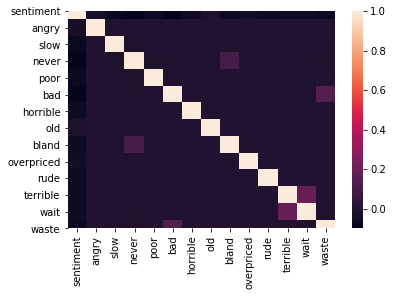

In [7]:
# Create heatmap 

sns.heatmap(yelp_raw.corr())

Since most of the words are not strongly correlated to each other. We will continue by building out our training data with SKLearn. In this step, we will specify an outcome and input variable. 

In [8]:
data = yelp_raw[neg_keywords]
target = yelp_raw['sentiment']

In [9]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 441


With our initial model, we missed classified 44.1% of the data points. 

To improve our model, let's calculate what kind of errors we're generating. First, we will use a confusion matrix to shows the count of each possible permutation of target and prediction. Then, use the information to calculate type 1 and type 2 errors. __Type 1__ errors are false positives where identify the review as negative, while it's not. On the other hand, __type 2__ errors are false negatives where we will failed to identify a negative review. 

In [10]:
# Generate confusion matrix

confusion1 = confusion_matrix(target, y_pred)

pd.DataFrame(
    confusion1, 
    columns=["Negatives", "Positives"],
    index=["Negatives", "Positives"])

,Negatives,Positives
Negatives,65,435
Positives,6,494


In [11]:
# Calculate type 1 and type 2 error

type1_error = confusion1[1][0]/(confusion1[1][0]+confusion1[1][1])*100
print('Type 1 error: '+str(type1_error)+'%')

type2_error = confusion1[0][1]/(confusion1[0][0]+confusion1[0][1])*100
print('Type 2 error: '+str(type2_error)+'%')

Type 1 error: 1.2%
Type 2 error: 87.0%


Our current model is sensitive in classifying positive reviews since we only missclassifed 1.2% of the reviews as positive. However, there is a high precentage of type 2 error which indicates our specifity method in identifying negative reviews is not efficent. We failed to identify 87% of the negative reviews as negative. 